In [34]:

import traceback
import os
import nflows as nf
from nflows.utils.torchutils import create_random_binary_mask
from nflows.transforms.base import CompositeTransform
from nflows.transforms.coupling import *
from nflows.nn import nets
from nflows.flows.base import Flow
from nflows.flows import base
from nflows.transforms.coupling import *
from nflows.transforms.autoregressive import *
from particle_net import ParticleNet
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR,ReduceLROnPlateau,ExponentialLR
import torch
from torch import nn
from torch.nn import functional as FF
import numpy as np
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
import mplhep as hep
import hist
from hist import Hist
from pytorch_lightning.loggers import TensorBoardLogger
from collections import OrderedDict
from ray import tune
from helpers import *
from plotting import *
import pandas as pd
import os

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import time
class plotting_paper():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,true,gen,config,p,model=None,logger=None,weight=1):
        self.config=model.config
        self.n_dim=self.config["n_dim"]
        self.gen=gen
        self.test_set=true

        self.model=model
        self.p=p

        self.weight=weight
        if logger is not None:
            self.summary=logger
    def plot_mass_only(self,m,m_t,bins=15):
        fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize=(6,8))
        a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
        b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
        a=np.quantile(m_t,0.001)
        b=np.quantile(m_t,0.999)
        h=hist.Hist(hist.axis.Regular(bins,a,b))
        h2=hist.Hist(hist.axis.Regular(bins,a,b))
        bins = h.axes[0].edges
        h.fill(m)#,weight=1/self.weight)
        h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )

        main_ax_artists, sublot_ax_arists = h.plot_ratio(
            h2,
            ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
            rp_ylabel=r"Ratio",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar
        )
        ax[0].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

        ax[1].set_ylim(0.25,2)
        ax[0].set_xlim(a,b)
        ax[1].set_xlabel("$m_T$",fontsize=22)
        ax[1].set_xlim(a,b)
        ax[0].set_ylabel("Counts" ,fontsize=18)
        ax[1].set_ylabel("Ratio",fontsize=18)
        # plt.savefig("{}_mass".format(self.p))
        plt.show()

    def plot_marginals(self,ith=None,title=None,save=None):
        #This plots the marginal distribution for simulation and generation
        #Note that this is the data the model sees during training as input to model in the NF
        #This is the distribution of one of [eta,phi,pt] of one particle of the n particles per jet: for example the pt of the 3rd particle
        #if save, the histograms are logged to tensorboard otherwise they are shown
        
        # plt.switch_backend('agg')
        i=str(ith)

        name,label=["eta","phi","pt"],['${{\eta}}^{{\\tt rel}}_{{{}}}$'.format(ith+1),"${{\phi}}^{{\\tt rel}}_{{{}}}$".format(ith+1),"${{p^{{\\tt rel}}_{{T,{}}}}}$".format(ith+1)]
        fig,ax=plt.subplots(2,3,gridspec_kw={'height_ratios': [3, 1]},figsize=(18,6))
        particles=[3*ith,3*ith+1,3*ith+2]
        pre=""
        if ith!=0:
            pre=str(ith+1)+"."
        plt.suptitle(pre+" Hardest Particle",fontweight="bold",fontsize=18)
        k=0
        for i in particles:


            ax_temp=ax[:,k]
           
            a=np.quantile(self.test_set[:,i].numpy(),0)
            b=np.quantile(self.test_set[:,i].numpy(),1)

            h=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h2=hist.Hist(hist.axis.Regular(15,a,b,label=label[i%3],underflow=False,overflow=False))
            h.fill(self.gen[:,i].numpy())
            h2.fill(self.test_set[:,i].numpy())
            
            plt.tight_layout()
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0,k] )
       
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax_temp[0],"ratio_ax":ax_temp[1]},
                rp_ylabel=r"Ratio",
#                 rp_xlabel=label[i%3],
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            
            
            ax_temp[0].set_xlabel("")
            ax_temp[1].set_ylim(0.25,2)
            ax_temp[0].set_xlim(a,b)
            ax_temp[1].set_xlim(a,b)
            ax_temp[1].set_xlabel(label[i%3],fontsize=22)
            ax_temp[0].set_ylabel("Counts" ,fontsize=18)
            ax_temp[1].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[0,k].get_legend().remove()
            #plt.tight_layout(pad=2)
            k+=1
        ax[0,-1].legend(loc="best",fontsize=18)  
        if not save==None:
            plt.savefig(save+str(ith)+".pdf",format="pdf")
        plt.show()


   
        
    def oversample(self,m,m_t,weight,save=None,quantile=False,bins=15,plot_vline=False,title=""):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(20,5))
        plt.suptitle(title)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{rel}$",r"$\phi^{rel}$",r"$p_T^{rel}$",r"$m^{rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i],weight=1/weight)
                
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                
                h.fill(m,weight=1/weight)#,weight=1/self.weight)
                h2.fill(m_t)
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
#             try:
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')


            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=18)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts" ,fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
#             except:
#                 print("mass plot failed reverting to simple plot mass bins")
#                 plt.close()
#                 plt.figure()
#                 _,b,_=plt.hist(m_t,15,label="Ground Truth",alpha=0.5)
#                 plt.hist(m,b,label="Generated",alpha=0.5)
#                 plt.legend()  
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
            plt.tight_layout(pad=1)
            k+=1
        if not save==None:
            
                plt.savefig(save+".pdf",format="pdf")

            
    def plot_mass(self,m,m_t,save=None,quantile=False,bins=15,plot_vline=False,title="",leg=-1):
        #This creates a histogram of the inclusive distributions and calculates the mass of each jet
        #and creates a histogram of that
        #if save, the histograms are logged to tensorboard otherwise they are shown
        #if quantile, this also creates a histogram of a subsample of the generated data, 
        # where the mass used to condition the flow is in the first 10% percentile of the simulated mass dist
        i=0
        k=0
        fig,ax=plt.subplots(2,4,gridspec_kw={'height_ratios': [3, 1]},figsize=(24,6))
        plt.suptitle("All Particles",fontweight="bold",fontsize=18)
        for v,name in zip(["eta","phi","pt","m"],[r"$\eta^{\tt rel}$",r"$\phi^{\tt rel}$",r"$p_T^{\tt rel}$",r"$m^{\tt rel}$"]):
            
            if v!="m":
                a=min(np.quantile(self.gen[:,i],0.001),np.quantile(self.test_set[:,i],0.001))
                b=max(np.quantile(self.gen[:,i],0.999),np.quantile(self.test_set[:,i],0.999))     
                temp=self.test_set[:,i].numpy()
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                h.fill(self.gen[:,i])
                h2.fill(self.test_set[:,i])
                i+=1
            else:
                a=min(np.quantile(m_t,0.001),np.quantile(m,0.001))
                b=max(np.quantile(m_t,0.999),np.quantile(m,0.999))
                a=np.quantile(m_t,0.001)
                b=np.quantile(m_t,0.999)
                h=hist.Hist(hist.axis.Regular(bins,a,b))
                h2=hist.Hist(hist.axis.Regular(bins,a,b))
                #bins = h.axes[0].edges
                h.fill(m)#,weight=1/self.weight)
                h2.fill(m_t)
                temp=m_t
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
        
            main_ax_artists, sublot_ax_arists = h.plot_ratio(
                h2,
                ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
                rp_ylabel=r"Ratio",
                bar_="blue",
                rp_num_label="Generated",
                rp_denom_label="Ground Truth",
                rp_uncert_draw_type="line",  # line or bar
            )
            ax[0,k].set_xlabel("")
            

            # ax[0,k].patches[1].set_fc("orange")
            # ax[0,k].patches[1].set_alpha(0.5)
#                 if quantile and v=="m" and plot_vline:
#                     ax[0,k].hist(m[m_t<np.quantile(m_t,0.1)],histtype='step',bins=bins,alpha=1,color="red",label="10% quantile gen",hatch="/")
#                     ax[0,k].vlines(np.quantile(m_t,0.1),0,np.max(h[:]),color="red",label='10% quantile train')

            #ax[0,k].hist(temp,bins=bins,color="orange",alpha=0.5)  
            ax[0,k].patches[1].set_fill(True)
            ax[0,k].patches[1].set_fc("orange")
            ax[0,k].patches[1].set_alpha(0.3) 
            ax[1,k].set_ylim(0.25,2)
            ax[0,k].set_xlim(a,b)
            ax[1,k].set_xlabel(name,fontsize=22)
            ax[1,k].set_xlim(a,b)
            ax[0,k].set_ylabel("Counts", fontsize=18)
            ax[1,k].set_ylabel("Ratio",fontsize=18)
            ax[0,k].get_legend().remove()
            k+=1
#                 if plot_vline:
#                        ax[0,k].legend(["Generated","Training","10% quantile Gen","10% quantile Sim"] )
#                 else:
#                       ax[0,k].legend(["Flow Generated","MC Simulated"] )
            
            #hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
            
#             plt.xlabel(name)
        
        ax[0,leg].legend(loc="best",fontsize=18)  
        plt.tight_layout(pad=1)
        

        
        if not save==None:
            plt.savefig(save+".pdf",format="pdf")
        plt.show()

class LitNF(pl.LightningModule):
    
   
    def create_resnet(self,in_features, out_features):
        '''This is the network that outputs the parameters of the invertible transformation
        The only arguments can be the in dimension and the out dimenson, the structure
        of the network is defined over the config which is a class attribute
        Context Features: Amount of features used to condition the flow - in our case 
        this is usually the mass
        num_blocks: How many Resnet blocks should be used, one res net block is are 1 input+ 2 layers
        and an additive skip connection from the first to the third'''
        c=self.config["context_features"]
        return nets.ResidualNet(
                in_features,
                out_features,
                hidden_features=self.config["network_nodes"],
                context_features=c,
                num_blocks=self.config["network_layers"],
                activation=self.config["activation"]  if "activation" in self.config.keys() else FF.relu,
                dropout_probability=self.config["dropout"] if "dropout" in self.config.keys() else 0,
                use_batch_norm=self.config["batchnorm"] if "batchnorm" in self.config.keys() else 0,

                    )
    def __init__(self,config,hyperopt):
        
        '''This initializes the model and its hyperparameters'''
        super().__init__()
        self.config=config
        self.counter=0 #This counts how many nan grads we have, we break after 5 in a row
        self.hyperopt=hyperopt
        #Metrics to track during the training
        self.metrics={"val_w1p":[],"val_w1m":[],"val_w1efp":[],"val_cov":[],"val_mmd":[],"val_fpnd":[],"val_logprob":[],"step":[]}
        #Loss function of the Normalizing flows
        self.logprobs=[]
        
        self.hparams.update(config)
        self.save_hyperparameters()
        #This is the Normalizing flow model to be used later, it uses as many
        #coupling_layers as given in the config 
        self.flows = []
        self.p=config["p"]
        self.n_dim=self.p*3
        K=self.config["coupling_layers"]
        for i in range(K):
            '''This creates the masks for the coupling layers, particle masks are masks
            created such that each feature particle (eta,phi,pt) is masked together or not'''
            mask=create_random_binary_mask(self.n_dim)  
            if "particle_masks" in self.config.keys() and self.config["particle_masks"] :
                mask=create_random_binary_mask(self.n_dim//3)            
                mask=mask.repeat_interleave(3)
            #Here are the coupling layers of the flow. There seem to be 3 choices but actually its more or less only 2
            #The autoregressive one is incredibly slow while sampling which does not work together with the constraint
            if self.config["spline"]=="autoreg":
                self.flows += [MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                    features=self.n_dim,
                    num_blocks=self.config["network_layers"], 
                    hidden_features=self.config["network_nodes"],
                    context_features=self.config["context_features"] ,
                    tails='linear',
                    tail_bound=self.config["tail_bound"],
                    num_bins=self.config["bins"],
                    use_residual_blocks=False,
                    use_batch_norm=self.config["batchnorm"],
                    activation=self.config["activation"])]
            
            elif self.config["spline"]:
                    
                    self.flows += [PiecewiseRationalQuadraticCouplingTransform(
                        mask=mask,
                        transform_net_create_fn=self.create_resnet, 
                        tails='linear',
                        tail_bound=self.config["tail_bound"],
                        num_bins=self.config["bins"] )]

            else:
                self.flows+=[ AffineCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=self.create_resnet)]
        #This sets the distribution in the latent space on which we want to morph onto        
        self.q0 = nf.distributions.normal.StandardNormal([self.n_dim])
        self.q_test =nf.distributions.normal.StandardNormal([self.n_dim])
        #Creates working flow model from the list of layer modules
        self.flows=CompositeTransform(self.flows)
        # Construct flow model
        self.flow_test= base.Flow(distribution=self.q_test, transform=self.flows)
        self.flow = base.Flow(distribution=self.q0, transform=self.flows)
        
    def build_disc(self,config=None):
        '''this builds a discriminator that can be used to distinguish generated from real
        data, optimally we would want it to have a 50% accuracy, meaning it can distinguish
        This is just a Feed Forward Neural Network
        The wgan keyword makes it a Wasserstein type of discriminator/critic
        I played around with this but it did not work particularly well'''
        if config:
                settings = {
                "conv_params": [
                    (8, (64, 64, 64)),
                    (8, (128, 128, 128)),
                    (8, (128, 128, 128)),
                ],
                "fc_params": [
                    (0.0, 128)
                ],
                "input_features": 3,
                "output_classes": self.config["context_features"]}
                self.particle_net=ParticleNet(settings)
                
                return 0


    def load_datamodule(self,data_module):
        '''needed for lightning training to work, it just sets the dataloader for training and validation'''
        self.data_module=data_module
        
    def on_after_backward(self) -> None:
        '''This is a genious little hook, sometimes my model dies, i have no clue why. This saves the training from crashing and continues'''
        valid_gradients = False
        for name, param in self.named_parameters():
            if param.grad is not None:
                valid_gradients = not (torch.isnan(param.grad).any() or torch.isinf(param.grad).any())
                if not valid_gradients:
                    break
        if not valid_gradients:
#             print("not valid grads",self.counter)
            self.zero_grad()
            self.counter+=1
            if self.counter>5:
                ValueError('5 nangrads in a row')
        else:
            self.counter=0
    def sampleandscale(self,batch,c=None,n=None):
        '''This is a helper function that samples from the flow (i.e. generates a new sample) 
            and reverses the standard scaling that is done in the preprocessing. This allows to calculate the mass
            on the generative sample and to compare to the simulated one, we need to inverse the scaling before calculating the mass
            because calculating the mass is a non linear transformation and does not commute with the mass calculation''' 
        x=batch[:,:self.n_dim].to(self.device),
        self.data_module.scaler.to(self.device)
        self.flow.to(self.device)
        if self.config["context_features"]>0:            
            gen=self.flow.sample(1,c).reshape(-1,self.n_dim).to(self.device)
            
        else:
            gen=self.flow.sample(len(batch)).reshape(-1,self.n_dim).to(self.device)
          
        #This make sure that everything is on the right device

        #Not here that this sample is conditioned on the mass of the current batch allowing the MSE 
        #to be calculated later on
        gen=self.data_module.scaler.inverse_transform(torch.hstack((gen[:,:self.n_dim]
            .reshape(-1,self.n_dim),torch.ones(len(gen)).to(self.device).unsqueeze(1))))
        true=self.data_module.scaler.inverse_transform(batch[:,:self.n_dim+1].to(self.device)).to(self.device)
        m=true[:,self.n_dim]
        m_g=mass(gen[:,:self.n_dim].to(self.device) ,
                 self.config["canonical"]).to(self.device)
        gen=torch.column_stack((gen,m_g))
        return gen,true,m,m_g
        
    def configure_optimizers(self):
        self.batch_size=self.config["batch_size"]
        #learning rate
        self.lr=self.config["lr"]
        #Total Loss (can be a sum of multiple terms)
        self.losses=[]
        #mlosses are initialized with None during the time it is not turned on, makes it easier to plot
        self.mlosses=[None for i in range(min(self.config["n_mse_delay"],self.config["max_steps"]))]
        self.n_dim=self.config["n_dim"]  
        opt_g = torch.optim.AdamW(self.flow.parameters(), lr=self.lr)
        self.opt_g=opt_g
        if self.config["lr_schedule"]=="onecycle":
            scheduler = OneCycleLR(self.opt_g,max_lr=0.01,total_steps=self.config["max_steps"])
        elif self.config["lr_schedule"]=="exp":
            scheduler = ExponentialLR(self.opt_g,gamma=0.99)
        elif self.config["lr_schedule"]=="smart":
            scheduler = OneCycleLR(self.opt_g,"min")
        return ({'optimizer': opt_g, 'frequency': 1, 'scheduler':None if not self.config["lr_schedule"] else scheduler})
     
    def _summary(self,temp):
        if self.hyperopt:
            self.summary_path="/beegfs/desy/user/{}/{}/summary.csv".format(os.environ["USER"],self.config["name"])
            
            if os.path.isfile(self.summary_path):
                time.sleep(1)
                summary=pd.read_csv(self.summary_path).set_index(["index"])
                try:
                    if self.global_step==0:
                        self.id=int(summary.index.values[-1])+1
                except:
                    print("wrong index",self.index.values[-1])
                summary.loc[self.id,self.config.keys()]=self.config.values()
                summary.loc[self.id,temp.keys()]=temp.values()
                summary.to_csv(self.summary_path,index_label=["index"])
                
                    
            
            else:
                self.id=1
                summary=pd.DataFrame(temp,index=[1])
                summary.loc[self.id,self.config.keys()]=self.config.values()
                
            return summary
    
    def _results(self):
        self.metrics["step"].append(self.global_step)
        self.df=pd.DataFrame.from_dict(self.metrics)
        self.df.to_csv(self.logger.log_dir+"result.csv",index_label=["index"])
    
    def test_cond(self,num):
        """this sampels mass and number particle conditions in an autoregressive manner needed for data generation, 
        First the number particles are sampeled randomly from the pmf, and then the mass distribution for every case with 
        n particles is calculated - this distribution is then interpolated and a 1d flows is constructed """

        ns=self.data_module.n[torch.randint(low=0,high=len(self.data_module.n),size=(num,))]
        c=torch.empty((0,2 if self.config["context_features"]==2 else 1))
        n_stacked=torch.empty((0,1))
        counts=torch.unique(ns,return_counts=True)
        for n,count in zip(counts[0],counts[1]):
            m_temp=torch.tensor(self.data_module.mdists[int(n)][1](torch.rand(size=(count,)).numpy())).reshape(-1,1).float()
            n_temp=torch.tensor(int(n)).repeat(count).reshape(-1,1)
            if self.config["context_features"]==2:
                c_temp=torch.hstack((m_temp,n_temp))
                c=torch.vstack((c,c_temp)).float()
            elif self.config["context_features"]==1:
                c=torch.vstack((c,m_temp.reshape(-1,1))).float()
            else:
                c=None
            n_stacked=torch.vstack((n_stacked,n_temp.reshape(-1,1))).float()
        return c,n_stacked
    
    def training_step(self, batch, batch_idx,optimizer_idx=0,wgan=False):
        """training loop of the model, here all the data is passed forward to a gaussian
            This is the important part what is happening here. This is all the training we do """
        x,c= batch[:,:self.n_dim],batch[:,self.n_dim:]
        
        if self.config["oversampling"]:
            shuffle=[torch.randperm(30).to("cuda") for i in range(len(batch))]
            form=torch.Tensor((len(batch),30,3)).to("cuda").int()
            shuffle=torch.cat(shuffle,out=form).to("cuda").int()
            x=torch.gather(input=x.reshape(-1,30,3),index=shuffle.unsqueeze(-1).repeat(1,1,3).type(torch.int64),dim=1).reshape(-1,90)

        if self.config["context_features"]==1:
            c=c[:,0].reshape(-1,1)
        elif self.config["context_features"]==0:
            c=None
        self.opt_g.zero_grad()
        # This is the mass constraint, which constrains the flow to generate events with a mass which is the same as the mass it has been conditioned on, we can choose to not calculate this when we work without mass constraint to make training faster
        if self.config["calc_massloss"]  :
                self.gen,self.true,self.m,self.m_g=self.sampleandscale(batch,c=c)
                mloss=FF.mse_loss(self.m_g.to(self.device).reshape(-1),self.m.to(self.device).reshape(-1))
                assert not torch.any(self.m_g.isnan()) or not torch.any(self.m.isnan())
                self.mlosses.append(mloss.detach().cpu().numpy())
                self.log("mass_loss", mloss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        ##Normalizing Flow loss Normalizing Flow loss
        g_loss = -self.flow.to(self.device).log_prob(x,c if self.config["context_features"] else None).mean()/self.n_dim
        self.log("logprob", g_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True) 
        self.logprobs.append(g_loss.detach().cpu().numpy())
        #some conditions on when we want to actually add the mass loss to our training loss, if we dont add it, it is as it wouldnt exist
        if self.global_step>self.config["n_mse_delay"] and self.config["context_features"]>0 and self.config["calc_massloss"] and self.global_step<self.config["n_mse_turnoff"]:
            g_loss+=self.config["lambda"]*mloss
            self.log("combined_loss", g_loss, on_epoch=True, prog_bar=True, logger=True)
        self.losses.append(g_loss.detach().cpu().numpy())
        return OrderedDict({"loss":g_loss})
    
   
        
    def validation_step(self, batch, batch_idx):
        '''This calculates some important metrics on the hold out set (checking for overtraining)'''
        self.data_module.scaler.to("cpu")  
        batch=batch.to("cpu")

        if self.config["context_features"]==1:
            c=batch[:,-2].reshape(-1,1)
            n_true=batch[:,-1]
            batch=batch[:,:self.n_dim+1]
            
        elif self.config["context_features"]==0:
            c=None
            n_true=batch[:,-1]
            batch=batch[:,:self.n_dim+1]
        else:
            c=batch[:,-2:]
            n_true=batch[:,self.n_dim+1]
        #c=batch[:,-self.config["context_features"]:] if self.config["context_features"] else None #this is the condition
        c_test,n_test=self.test_cond(len(batch)) #this is the condition in the case of testing
        

        
        with torch.no_grad():
            # gen=self.flow_test.to("cpu").sample(len(batch) if c==None else 1,c).to("cpu")
            test=self.flow_test.to("cpu").sample(len(batch) if c==None else 1,c_test).to("cpu").reshape(-1,self.p*3)
            test=torch.hstack((test[:,:self.n_dim].cpu().detach().reshape(-1,self.n_dim),torch.ones(len(test)).unsqueeze(1)))
        # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
        test=self.data_module.scaler.inverse_transform(test)
        # gen=self.data_module.scaler.inverse_transform(gen)
        true=self.data_module.scaler.inverse_transform(batch[:,:self.n_dim+1])[:,:self.n_dim]
        # We overwrite in cases where n is smaller 30 the particles after n with 0
        # if self.config["context_features"]>1:
        #     for i in torch.unique(batch[:,-1]):
        #         i=int(i)
        #         gen[c[:,-1]==i,3*i:]=0
        #         test[c_test[:,-1]==i,3*i:-1]=0
        #This is just a nice check to see whether we overtrain 
        logprob = -self.flow.to("cpu").log_prob(batch[:,:self.n_dim],c ).detach().mean().numpy()/self.n_dim
        # if self.global_step > 100:
        #     if logprob > 1: ###Cut off logprob value
        #         raise ValueError('Logprob over 1')
        #calculate mass distrbutions & concat them to training sample
        m_t=mass(true[:,:self.n_dim].to(self.device),self.config["canonical"]).cpu()
        # m_gen=mass(gen[:,:self.n_dim],self.config["canonical"]).cpu()
        m_test=mass(test[:,:self.n_dim],self.config["canonical"]).cpu()
        # gen=torch.column_stack((gen[:,:90],m_gen))
        test=torch.column_stack((test[:,:self.p*3],m_test))       
        # Again checking for overtraining
        mse=FF.mse_loss(m_t,m_test).detach()
      
        # For one metric the pt needs to always be bigger or equal 0, so we overwrite the cases where it isnt (its not physical possible to ahve pt smaller 0)
        for i in range(self.p):
            i=2+3*i
            # gen[gen[:,i]<0,i]=0
            test[test[:,i]<0,i]=0
            true[true[:,i]<0,i]=0
          #Some metrics we track
        cov,mmd=cov_mmd(test[:,:self.n_dim].reshape(-1,self.n_dim//3,3),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3),use_tqdm=False)
        try:
            fpndv=fpnd(test[:,:self.n_dim].reshape(-1,self.n_dim//3,3).numpy(),use_tqdm=False,jet_type=self.config["parton"])
        except:
            fpndv=1000
        self.metrics["val_fpnd"].append(fpndv)
        self.metrics["val_logprob"].append(fpndv)
        self.metrics["val_mmd"].append(mmd)
        self.metrics["val_cov"].append(cov)
        self.metrics["val_w1p"].append(w1p(test[:,:self.n_dim].reshape(-1,self.n_dim//3,3),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["val_w1m"].append(w1m(test[:,:self.n_dim].reshape(-1,self.n_dim//3,3),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        self.metrics["val_w1efp"].append(w1efp(test[:,:self.n_dim].reshape(-1,self.n_dim//3,3),true[:,:self.n_dim].reshape(-1,self.n_dim//3,3)))
        
        
        temp={"val_logprob":logprob,"val_fpnd":fpndv,"val_mmd":mmd,"val_cov":cov,"val_w1m":self.metrics["val_w1m"][-1][0],"val_w1efp":self.metrics["val_w1efp"][-1][0],"val_w1p":self.metrics["val_w1p"][-1][0],"step":self.global_step}
        self.config["path"]=self.logger.log_dir
        print("step {}: ".format(self.global_step),temp)
        if self.hyperopt:
            self._results()
            summary=self._summary(temp)

        self.log("val_w1m",self.metrics["val_w1m"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1p",self.metrics["val_w1p"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_w1efp",self.metrics["val_w1efp"][-1][0],on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_logprob",logprob,prog_bar=True,logger=True)
        self.log("val_cov",cov,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_fpnd",fpndv,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_mmd",mmd,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        self.log("val_mse",mse,prog_bar=True,logger=True,on_step=False, on_epoch=True)
        # This part here adds the plots to tensorboard
        
        self.plot=plotting_paper(model=self,gen=test[:,:self.n_dim],true=true[:,:self.n_dim],config=self.config,p=config["parton"])
        self.plot.plot_mass(m_test.cpu().numpy(),m_t.cpu().numpy(),save="mass_{}.pdf".format(self.p),bins=15,quantile=True,plot_vline=False)
        for i in [0,5,7,25]:
            self.plot.plot_marginals(save="affine_marginals_",ith=i)
      

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /beegfs/desy/user/kaechben/variable_sized/2022_10_08-13_53-29/lightning_logs
LOCAL_RANK: 0 - CUDA_V

Sanity Checking: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: overflow encountered in _mass2_kernel
  result = getattr(ufunc, method)(
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in _mass2_kernel
  result = get

step 0:  {'val_logprob': 1.8523445977105035, 'val_fpnd': 1743.9454507940632, 'val_mmd': 0.3502832715343771, 'val_cov': 0.092, 'val_w1m': 0.3836891813833563, 'val_w1efp': 245.4226954149936, 'val_w1p': 0.1263794182588989, 'step': 0}


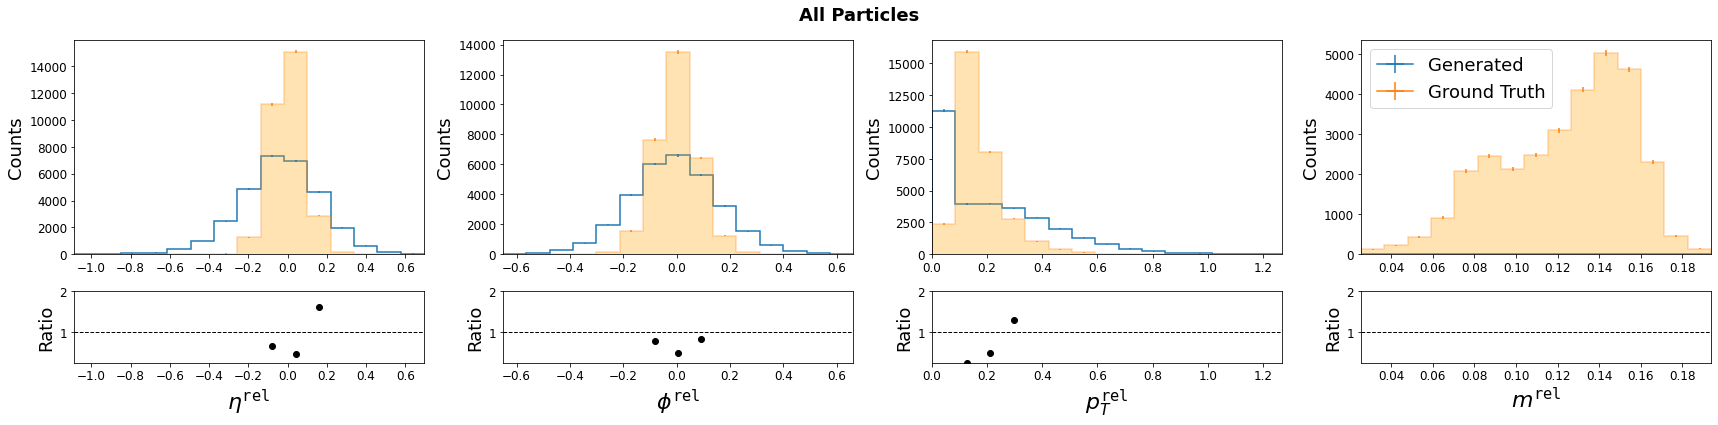

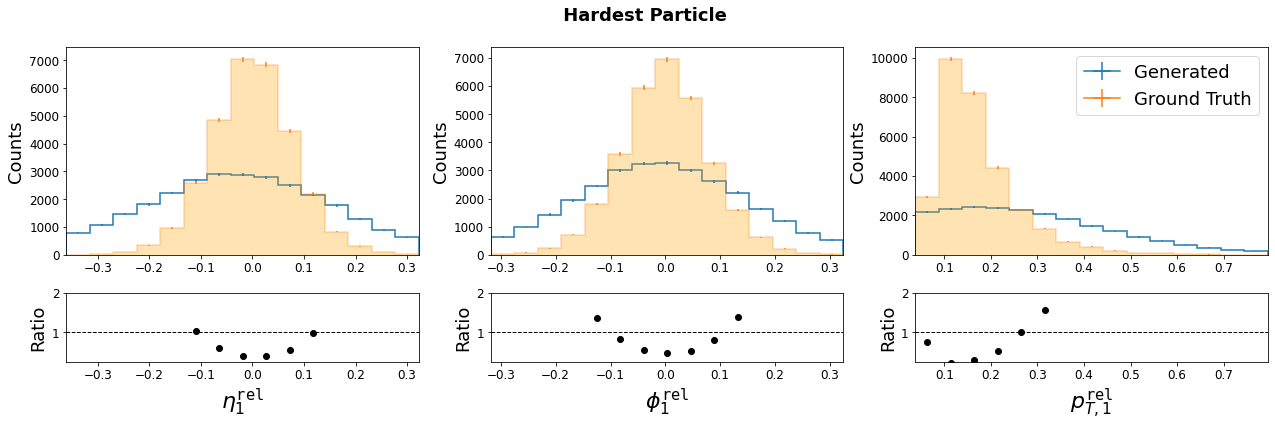

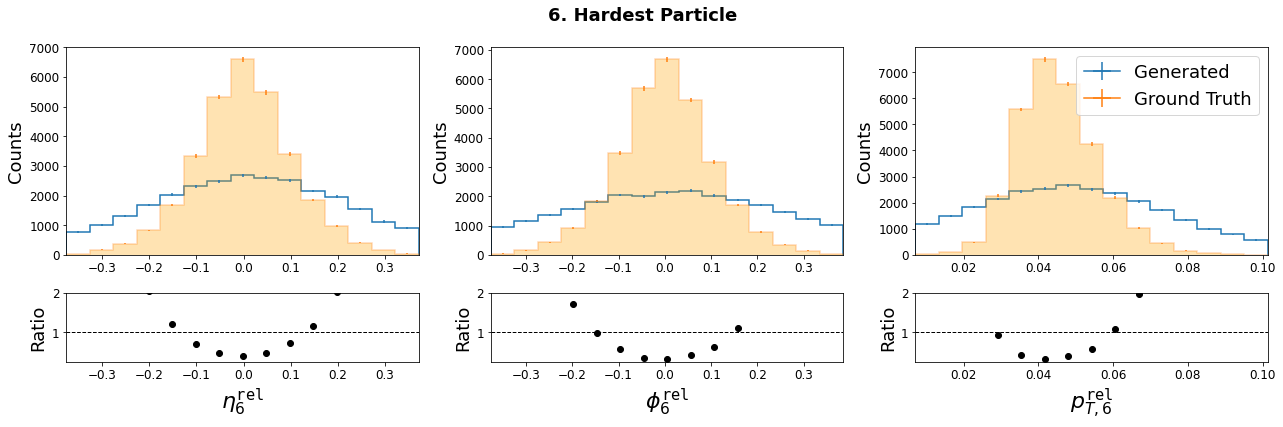

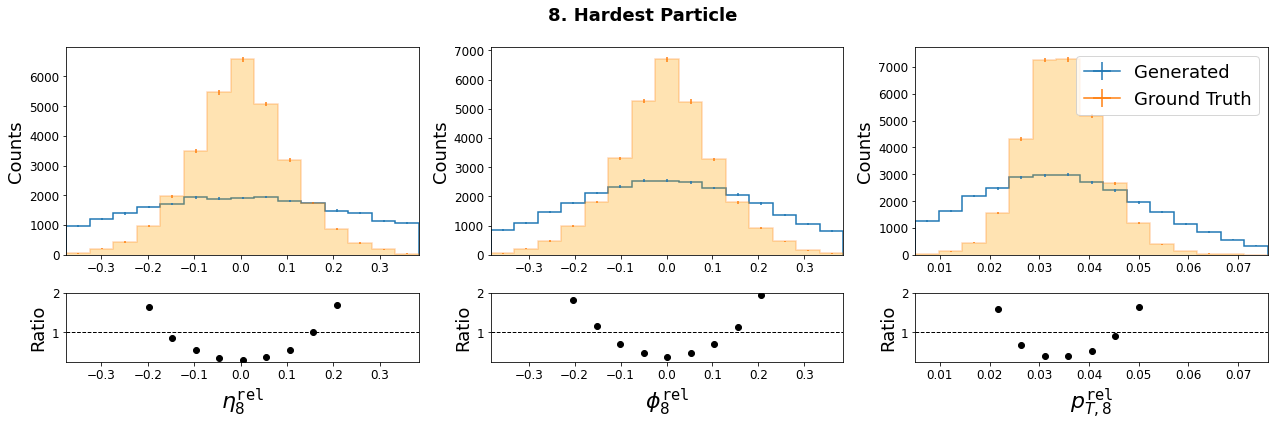

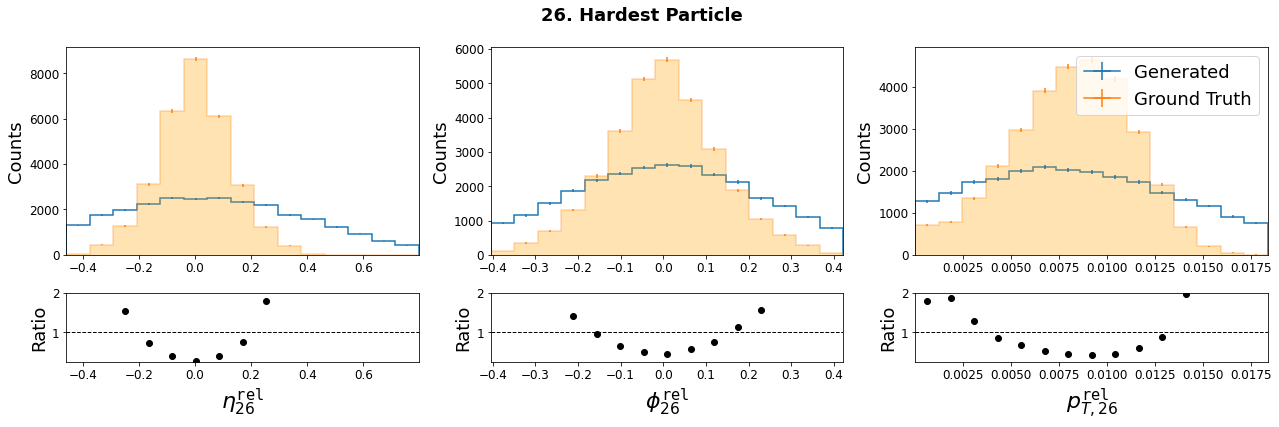

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


step 290:  {'val_logprob': 1.1374905056423612, 'val_fpnd': 176.37966894142198, 'val_mmd': 0.11962376098209568, 'val_cov': 0.348, 'val_w1m': 0.07041370174512268, 'val_w1efp': 0.004564910861717265, 'val_w1p': 0.03381133985346771, 'step': 290}


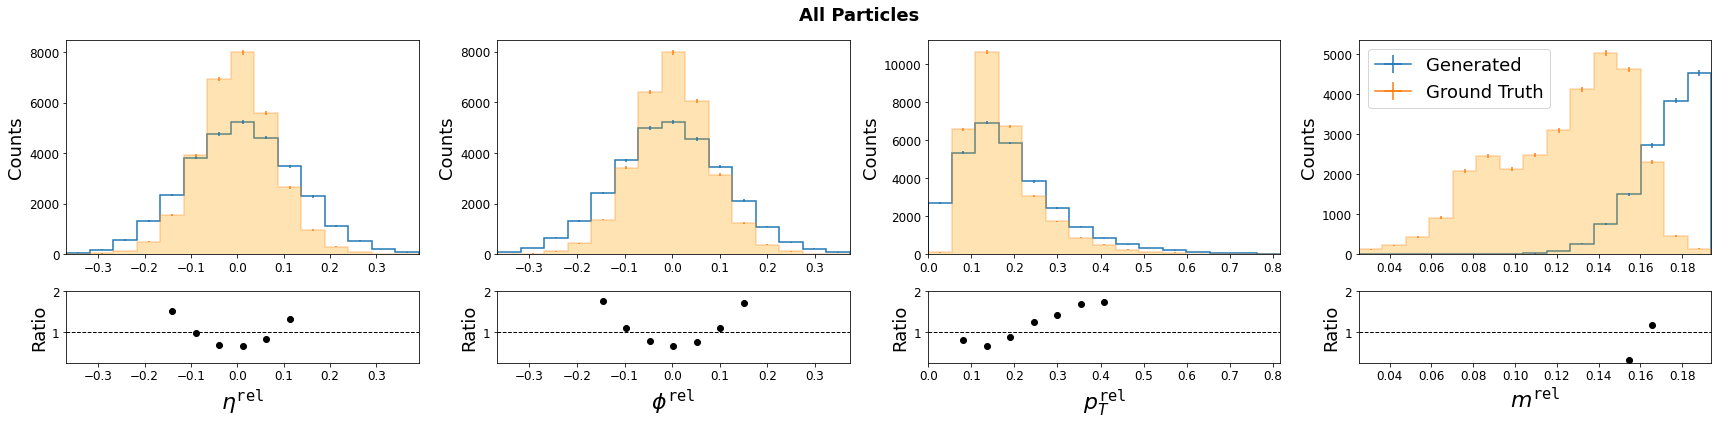

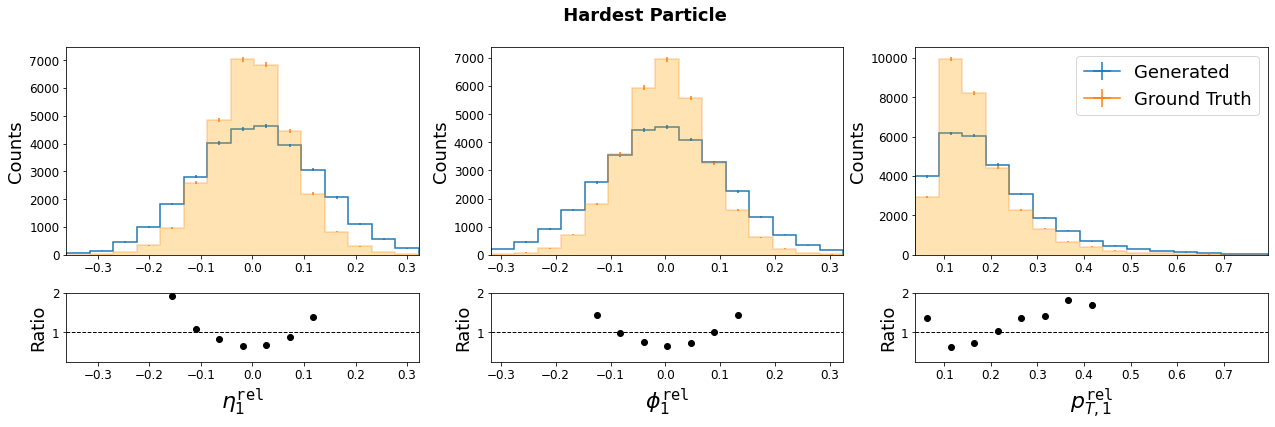

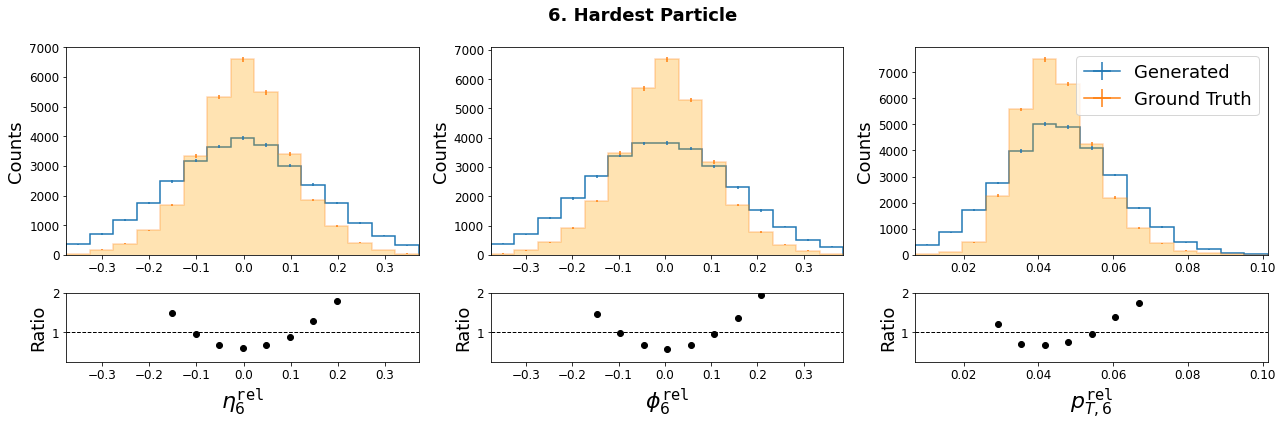

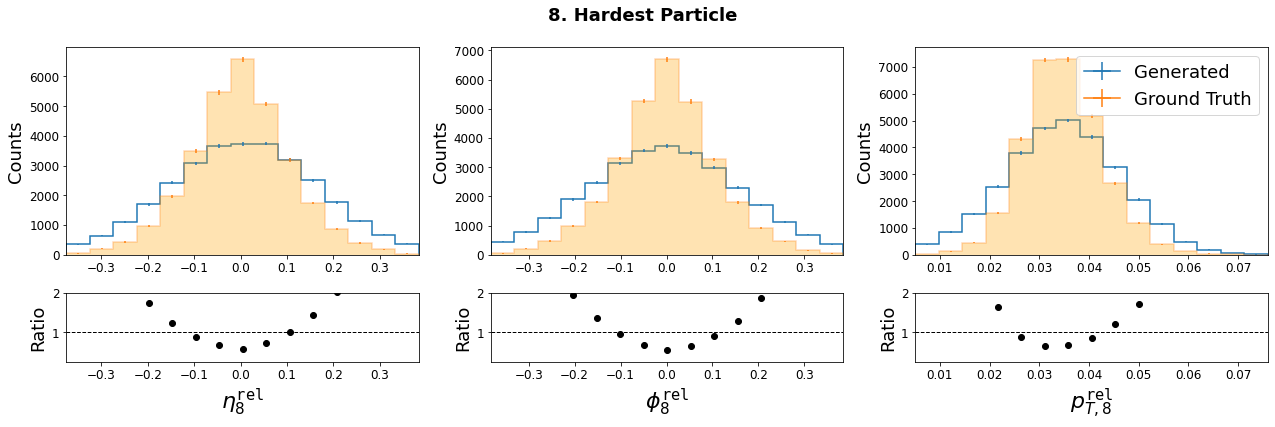

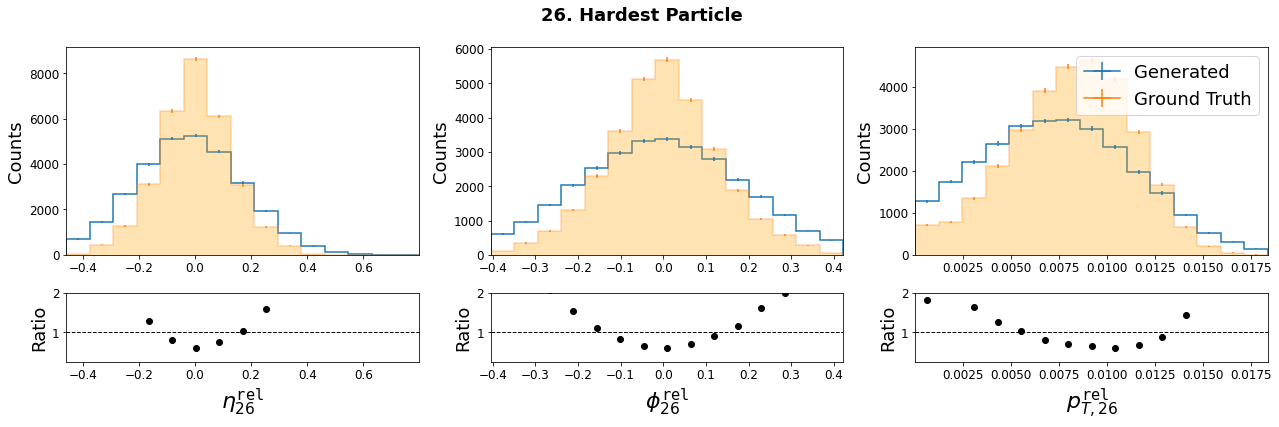

Validation: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


step 580:  {'val_logprob': 1.1137015448676215, 'val_fpnd': 192.1944065203765, 'val_mmd': 0.13070937477359085, 'val_cov': 0.294, 'val_w1m': 0.08334571830045431, 'val_w1efp': 0.006223054161410384, 'val_w1p': 0.04166170690212019, 'step': 580}


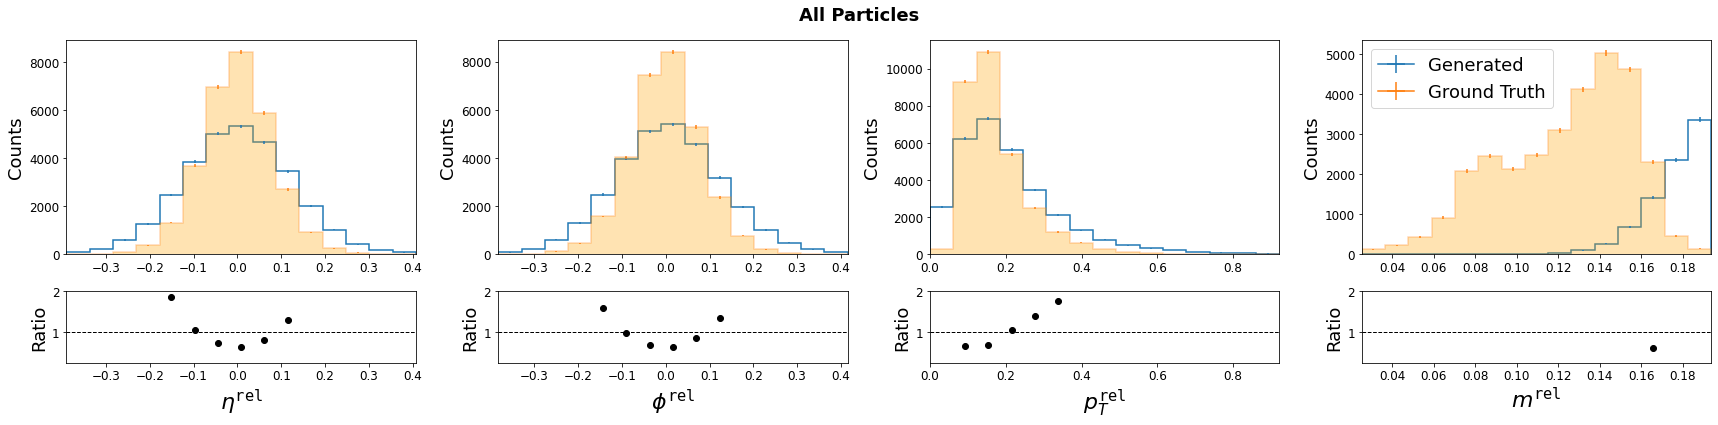

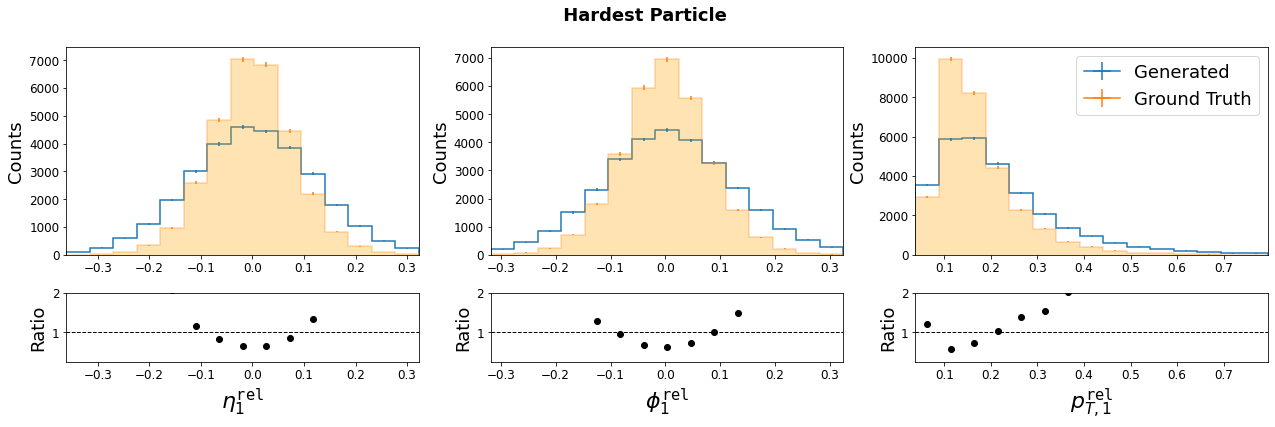

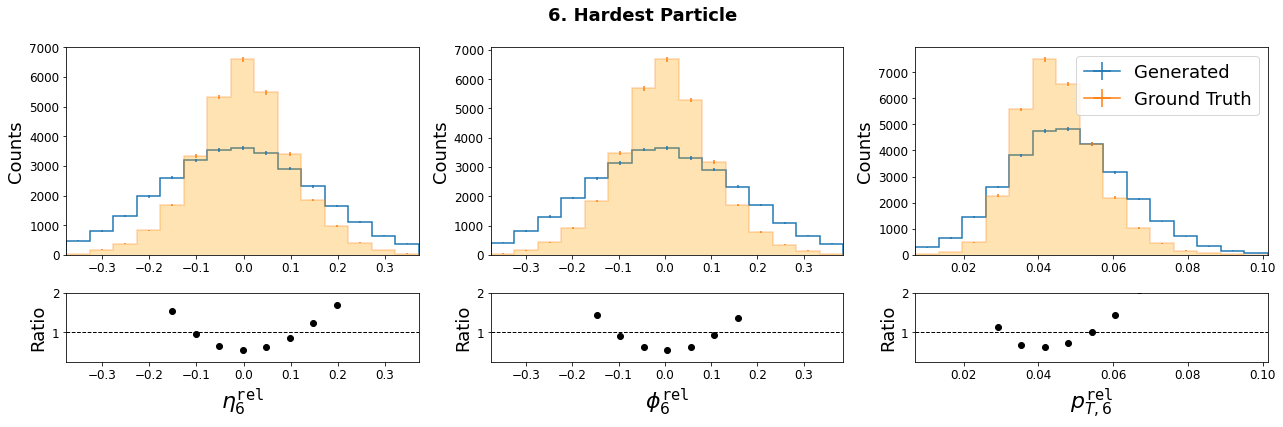

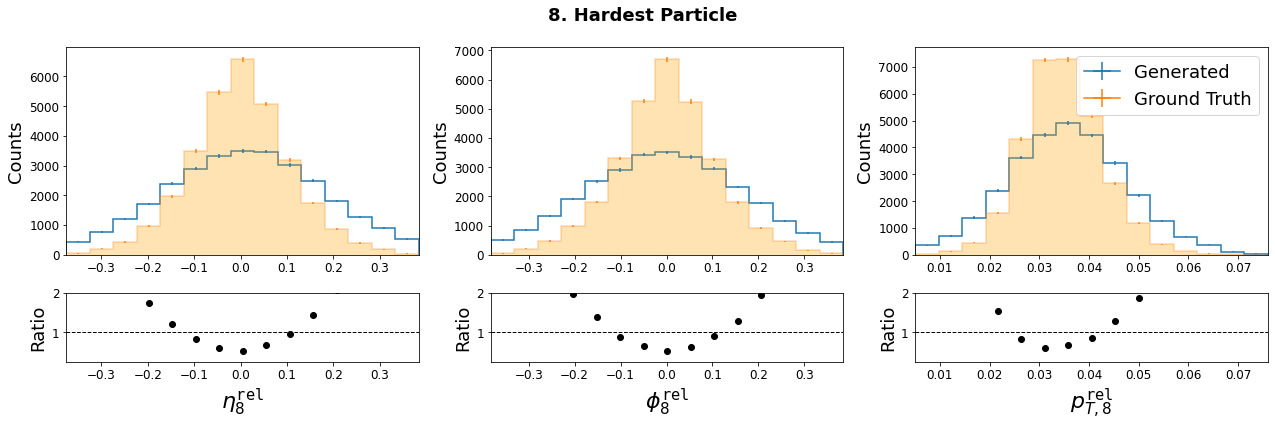

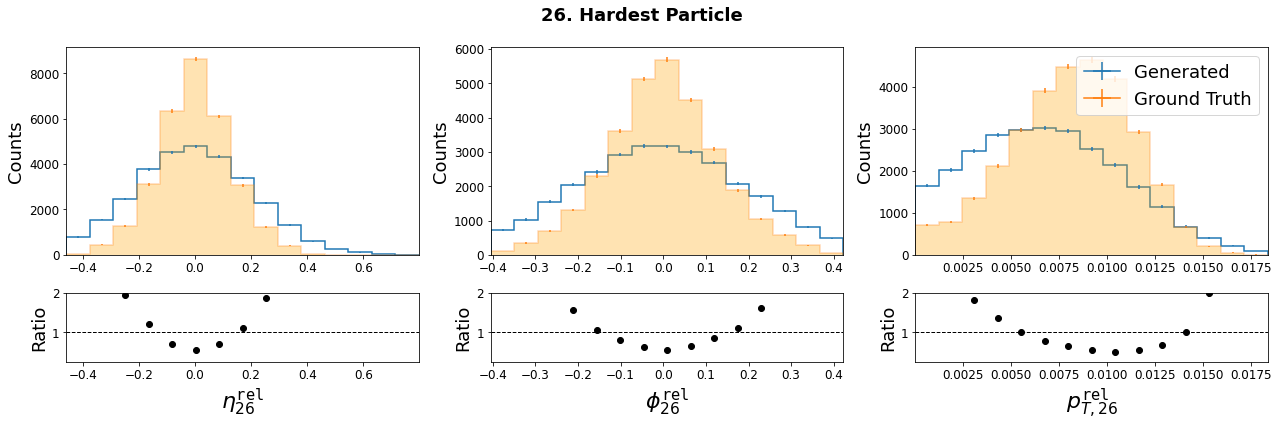

Validation: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(


step 870:  {'val_logprob': 1.1060204399956597, 'val_fpnd': 211.87901662200335, 'val_mmd': 0.13783988386761575, 'val_cov': 0.28300000000000003, 'val_w1m': 0.09236737072203308, 'val_w1efp': 0.007623014194980564, 'val_w1p': 0.04545848914203807, 'step': 870}


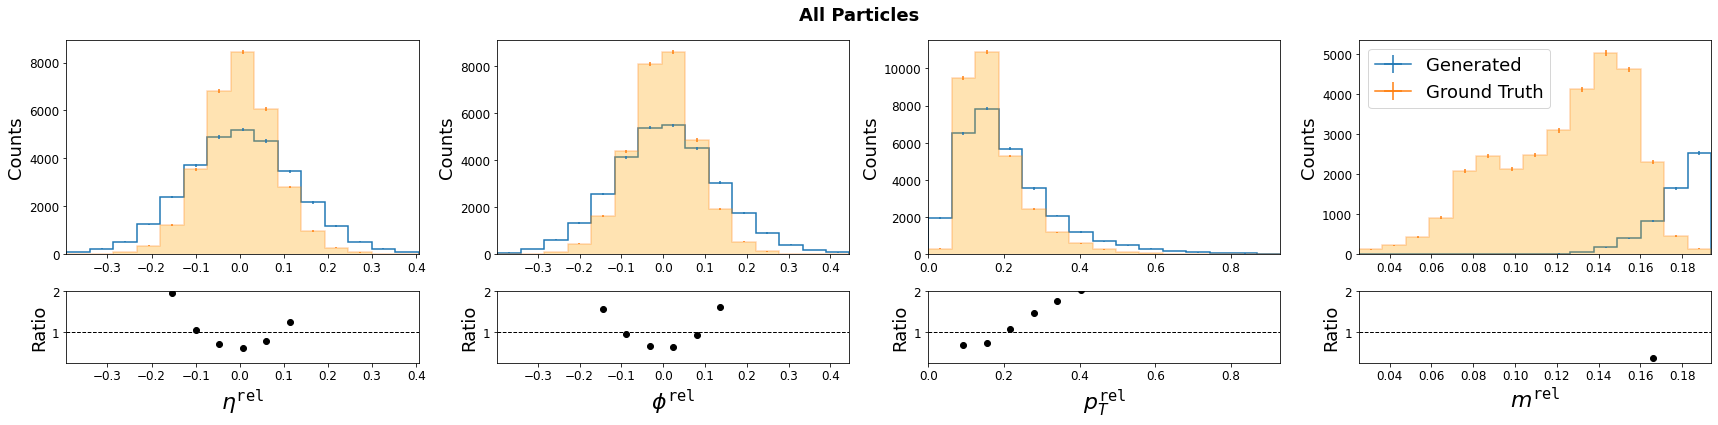

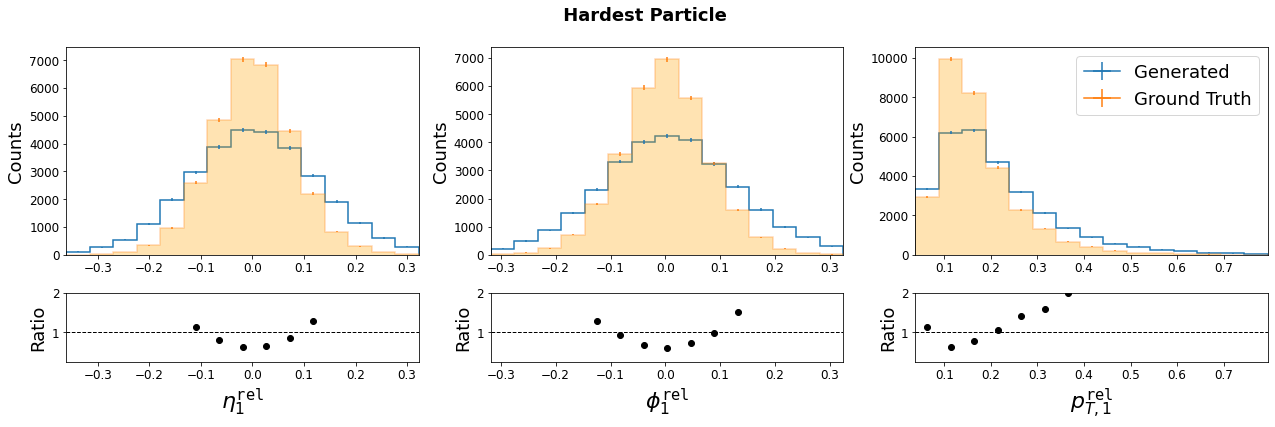

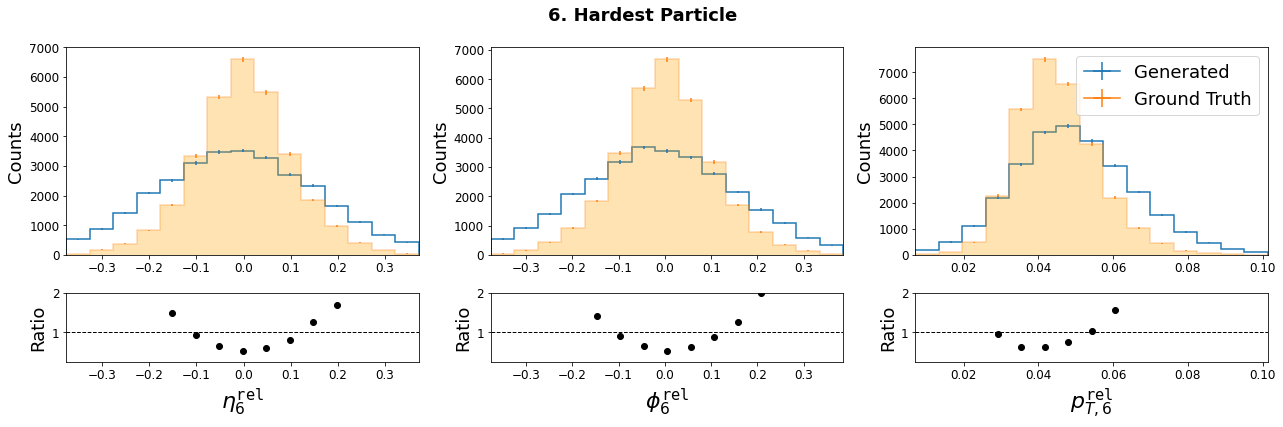

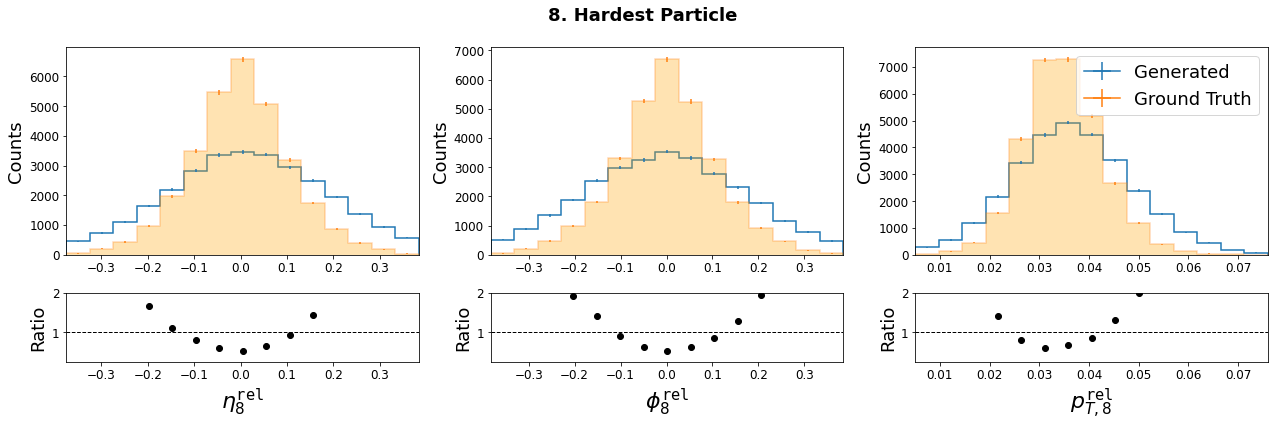

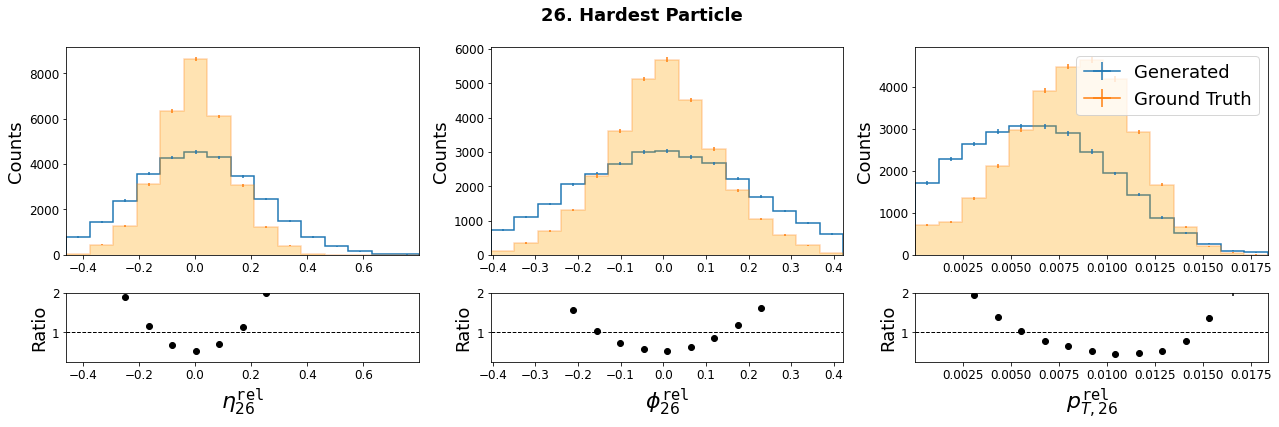

Validation: 0it [00:00, ?it/s]

/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/jetnet/evaluation/gen_metrics.py:239: RuntimeWarning: Recommended number of jets for FPND calculation is 50000
  warnings.warn(
/beegfs/desy/user/kaechben/.conda/envs/jetnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:
from pytorch_lightning.callbacks import ModelCheckpoint
# from comet_ml import Experiment

import pytorch_lightning as pl
import os
from plotting import plotting
from torch.nn import functional as FF

from jetnet_dataloader_variable import JetNetDataloader
from helpers import *
from ray import tune
import ray
from pytorch_lightning.loggers import CometLogger
from ray.tune import CLIReporter
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from ray.tune.integration.pytorch_lightning import TuneReportCheckpointCallback
import os
from scipy import stats
import datetime
import pandas as pd
import traceback
import time
def train(config, hyperopt=False, load_ckpt=None,i=0,root=None):
    # This function is a wrapper for the hyperparameter optimization module called ray 
    # Its parameters hyperopt and load_ckpt are there for convenience
    # Config is the only relevant parameter as it sets the trainings hyperparameters
    # hyperopt:whether to optimizer hyper parameters - load_ckpt: path to checkpoint if used
    data_module = JetNetDataloader(config) #this loads the data
    model = LitNF(config,hyperopt) # the sets up the model,  config are hparams we want to optimize
    # Callbacks to use during the training, we  checkpoint our models
    
    callbacks = [ModelCheckpoint(monitor="val_logprob",save_top_k=2, filename='{epoch}-{val_logprob:.2f}-{val_w1m:.4f}', dirpath=root,every_n_epochs=10) ]
    
    # if True:#load_ckpt:
    #     model = model.load_from_checkpoint("/beegfs/desy/user/kaechben/t/2022_06_22-10_50-16/epoch=1749-val_logprob=0.94-val_w1m=0.0153.ckpt")
    model.load_datamodule(data_module)#adds datamodule to model
    model.config = config #config are our hyperparams, we make this a class property now
    logger = TensorBoardLogger(root)
    #log every n steps could be important as it decides how often it should log to tensorboard
    # Also check val every n epochs, as validation checking takes some time
    
    trainer = pl.Trainer(gpus=1, logger=logger,  log_every_n_steps=100,  # auto_scale_batch_size="binsearch",
                          max_steps=100000 if config["oversampling"]  else config["max_steps"], callbacks=callbacks, progress_bar_refresh_rate=1,
                          check_val_every_n_epoch=10,track_grad_norm=2 ,num_sanity_val_steps=1,#gradient_clip_val=.02, gradient_clip_algorithm="norm",
                         fast_dev_run=False,default_root_dir=root,max_epochs=-1)
    # This calls the fit function which trains the model
    trainer.fit(model, train_dataloaders=data_module )  




hyperopt = False  # This sets to run a hyperparameter optimization with ray or just running the training once

config = {
   "network_layers": 2,  # sets amount hidden layers in transformation networks -scannable
    "network_nodes": 256,  # amount nodes in hidden layers in transformation networks -scannable
    "batch_size": 2500,  # sets batch size -scannable
    "coupling_layers": 10,  # amount of invertible transformations to use -scannable
    "lr": 0.001,  # sets learning rate -scannable
    "batchnorm": False,  # use batchnorm or not -scannable
    "bins": 8,  # amount of bins to use in rational quadratic splines -scannable
    "tail_bound": 6,  # splines:max value that is transformed, over this value theree is id  -scannable
    "limit": 100000,  # how many data points to use, test_set is 10% of this -scannable in a sense use 10 k for faster training
    "n_dim": 90,  # how many dimensions to use or equivalently /3 gives the amount of particles to use NEVER EVER CHANGE THIS
    "dropout": 0.4,  # use droput proportion, for 0 there is no dropout -scannable
    "lr_schedule": False,  # whether tos chedule the learning rate can be False or "smart","exp","onecycle" -semi-scannable
    "n_sched": 1000,  # how many steps between an annealing step -semi-scannable
    "canonical": False,  # transform data coordinates to px,py,pz -scannable
    "max_steps": 3000,  # how many steps to use at max - lower for quicker training
    "lambda": 10,  # balance between massloss and nll -scannable
    "n_mse_turnoff": 10000000,  # when to turn off mass loss -scannable
    "n_mse_delay": 5,  # when to turn on mass loss -scannable
    "name": "q",  # name for logging folder
    "disc": False,  # whether to train gan style discriminator that decides whether point is simulated or generated-semi-scannable
    "calc_massloss": True, # whether to calculate mass loss, makes training slower, do not use with autoregressive! 
    "context_features":0, #amount of variables used for conditioning, for 0 no conditioning is used, for 1 o nly the mass is used, for 2 also the number part is used
    "variable":1, #use variable amount of particles otherwise only use 30, options are true or false 
    "spline":False,#whether to use splines or not, can also be set to "autoregressive" but they are unstable
    "parton":"t", #choose the dataset you want to train options: t for top,q for quark,g for gluon
    "oversampling":False,
    "p":30
}
config["n_dim"]=config["p"]*3
config["name"]=config["parton"]
config["name"]="variable_sized"
root="/beegfs/desy/user/"+os.environ["USER"]+"/"+config["name"]+"/"+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M-%S")

if not hyperopt:
    hyperopt=True
    train(config,hyperopt=hyperopt,root=root)

    # reporter.add_metric_column("m_loss")
    # reporter.add_metric_column("logprob")
    # reporter.add_metric_column("val_w1p")
    # reporter.add_metric_column("val_w1efp")
    # reporter.add_metric_column("val_w1m")
    # ray.init("auto") # This connects to the main ray node

    #this starts the training 
    # result = tune.run(tune.with_parameters(
    #     train,  hyperopt=True),
    #     resources_per_trial=resources,
    #     config=config,
    #     num_samples=num_samples,
    #     progress_reporter=reporter,
    #     # checkpoint_freq=100,  # Checkpoint every 100 epoch
    #     local_dir="/beegfs/desy/user/"+os.environ["USER"]+"/ray_results/"+config["name"]+"/",
    #     verbose=2,
    # )


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.datasets import make_moons
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt
config={
        "network_layers":2,
        "network_nodes":128,
        "batch_size":2000,
        "coupling_layers":15,#tune.uniform(3,20),#tune.randint(6,300),
        "conditional":True,
        "lr":0.0001,
        "batchnorm":False,
        "autoreg":False,
        "bins":8,
        "UMNN":False,
        "tail_bound":10,
        "n_mse_delay":10,
        "limit":100000,
        "n_dim":90,
        "dropout":0.0,
        "lr_schedule":False,
        "gamma":0.75,
        "n_sched":1000,
        "canonical":False,
        "max_steps":100000,
        "lambda":500,
        "n_mse_turnoff":1000,
        "name":"debug",
        "disc":False,
        "activation":FF.leaky_relu,
        "particle_masks":True,
        "calc_massloss":True
        }

data_module = JetNetDataloader(config)
model=LitNF(config=config)
logger= TensorBoardLogger("lightning_logs", name=config["name"],log_graph=False)
checkpoint_callbacks = [
                        ModelCheckpoint(monitor="val_w1m",filename="best_mass-{}".format(config["n_dim"])),
                         ModelCheckpoint(monitor="val_w1p",filename="best_logprob-{}".format(config["n_dim"]))
,pl.callbacks.StochasticWeightAveraging(75)]
    #EarlyStopping(monitor="val_w1m", mode="min",min_delta=0.0001,patience=5)]
path="lightning_logs/debug/version_16/checkpoints/"
#path="LitJetNet/best_model/checkpoints/"

ckpt=os.listdir(path)[0]
# model.build_discriminator()
model=LitNF.load_from_checkpoint(path+ckpt)
model.load_datamodule(data_module)
model.config=config

model.lr=config["lr"]
trainer = pl.Trainer(gpus=1,log_every_n_steps=10,#auto_scale_batch_size="binsearch",
                     auto_lr_find=False,max_epochs=1000,callbacks=checkpoint_callbacks,
                     gradient_clip_val=0.5, gradient_clip_algorithm="value",check_val_every_n_epoch=10  
                    ,fast_dev_run=False,logger=logger,stochastic_weight_avg=False)
# # # trainer.tune(model,data_module)
# # # lr_finder = trainer.tuner.lr_find(model,data_module, early_stop_threshold=100, min_lr=1e-5)
trainer.fit(model,train_dataloaders=data_module, ckpt_path=checkpoint_callbacks[0].best_model_path)
# # # # print("hello")

In [66]:
import jetnet
import pandas as pd
import numpy as np
from tkinter import W


def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"
tex=""
q=jetnet.datasets.JetNet("q",normalize=False).data.numpy()
nq=q[:,:,-1].sum(axis=-1)
g=jetnet.datasets.JetNet("g",normalize=False).data.numpy()
ng=g[:,:,-1].sum(axis=-1)
t=jetnet.datasets.JetNet("t",normalize=False).data.numpy()
nt=t[:,:,-1].sum(axis=-1)
for p,name in zip([g,q,t],["g","q","t"]):
    _w1p=jetnet.evaluation.w1p(p[:,:,:3],p[:,:,:3])
    _w1m=jetnet.evaluation.w1m(p[:,:,:3],p[:,:,:3])
    _w1efp=jetnet.evaluation.w1efp(p[:,:,:3],p[:,:,:3])
    cov,mmd=jetnet.evaluation.cov_mmd(p[:50000],p[:50000])

    fpndv=jetnet.evaluation.fpnd(p[:50000,:,:3],jet_type=name)



    print_table=pd.DataFrame(np.array([_w1m[0],_w1p[0],_w1efp[0],fpndv,cov,mmd,_w1m[1],_w1p[1],_w1efp[1],name]).reshape(1,10),columns=["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","parton"])

    print_table.loc[:,"w1m"]=print_table.loc[:,"w1m"].astype(float)*1000
    print_table.loc[:,"w1p"]=print_table.loc[:,"w1p"].astype(float)*1000
    print_table.loc[:,"w1efp"]=print_table.loc[:,"w1efp"].astype(float)*100000
    print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float)*1000
    print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float)*1000
    print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float)*100000
    print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
    print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
    print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)


    print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
    print_table.loc[:,"fpnd"]=print_table.loc[:,"fpnd"].astype(float).map('{:.2f}'.format)
    print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)

    print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

    print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

    print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
#     print_table.loc[:,"parton"]=print_table.index.str[-1]
    # print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
    # print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
    # print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
    print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
    print_table.loc[:,"fpnd"]="$"+print_table["fpnd"].map(str)+"$"
    print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"
    for col in print_table.columns:

        if col not in ["w1m","w1p","w1efp","fpnd","cov","mmd" ]:
            continue
        temp=print_table
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
#         temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["w1m","w1p","w1efp","fpnd","cov","mmd"]]
    temp.columns=["$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if name=="g" else "Light Quark" if name=="q" else "Top Quark"
    tex+=parton+" & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)

Running ParticleNet: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [00:28<00:00, 109.67it/s]
/tmp/ipykernel_15289/3855318657.py:79: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_15289/3855318657.py:84: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)
Running ParticleNet: 100%|███████████████████████████████████████████████████

'Gluon & \n\n $0.5 \\pm 0.1$ &$0.4 \\pm 0.2$ & $0.4 \\pm 0.4$ & $0.01$ & $0.56$ & $0.036$ \\\\\\cline{1-8}\nLight Quark & \n\n $0.42 \\pm 0.09$ &$0.6 \\pm 0.4$ & $0.5 \\pm 0.5$ & $0.01$ & $0.55$ & $0.024$ \\\\\\cline{1-8}\nTop Quark & \n\n $0.5 \\pm 0.1$ &$0.6 \\pm 0.4$ & $1.1 \\pm 0.4$ & $0.03$ & $0.56$ & $0.072$ \\\\\\cline{1-8}\n'

In [67]:
print(tex)

Gluon & 

 $0.5 \pm 0.1$ &$0.4 \pm 0.2$ & $0.4 \pm 0.4$ & $0.01$ & $0.56$ & $0.036$ \\\cline{1-8}
Light Quark & 

 $0.42 \pm 0.09$ &$0.6 \pm 0.4$ & $0.5 \pm 0.5$ & $0.01$ & $0.55$ & $0.024$ \\\cline{1-8}
Top Quark & 

 $0.5 \pm 0.1$ &$0.6 \pm 0.4$ & $1.1 \pm 0.4$ & $0.03$ & $0.56$ & $0.072$ \\\cline{1-8}



(5.72341425176674e-06, 6.051371252512778e-06)

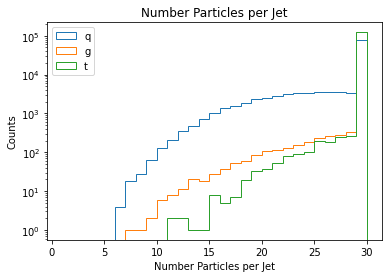

In [19]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax=plt.subplots()
bins=np.array(range(30))+1
ax.hist(nq,bins=bins,histtype="step",label="q")
ax.hist(ng,bins=bins,histtype="step",label="g")
ax.hist(nt,bins=bins,histtype="step",label="t")
ax.legend(loc="upper left")
plt.yscale("log")
plt.title("Number Particles per Jet")
plt.xlabel("Number Particles per Jet")
plt.ylabel("Counts")
plt.savefig("n.pdf",format="pdf")
plt.show()


In [ ]:
efp_q=jetnet.utils.efps(q)
efp_t=jetnet.utils.efps(t)
efp_g=jetnet.utils.efps(g)
fig,ax=plt.subplots()

_,bins,_=ax.hist(efp_q[:,0],histtype="step",label="q",bins=30)
ax.hist(efp_g[:,0],bins=bins,histtype="step",label="g")
ax.hist(efp_t[:,0],bins=bins,histtype="step",label="t")
ax.legend(loc="upper right")
plt.yscale("log")
plt.title(r"Energy Flow Polynomial $n=4,\ d=5$")
plt.xlabel("EFP")
plt.ylabel("Counts")
plt.savefig("n.pdf",format="pdf")
plt.show()


[0.00498213 0.00713724 0.01022459 0.01464743 0.02098345 0.03006023
 0.04306334 0.0616912  0.08837688 0.12660596 0.18137174 0.25982748
 0.37222073 0.53323179 0.76389119]


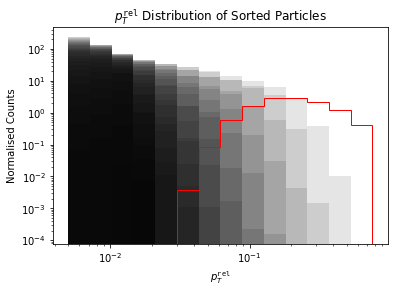

In [25]:
bins=np.logspace(np.log(0.1),np.log(np.max(q[:,0,2])),15)
print(bins)
_,bins,_=plt.hist(q[:,0,2],bins=bins,color='red',histtype="step",density=1)
for i in range(29):
    plt.hist(q[:,i+1,2],bins=bins,histtype="stepfilled",alpha=0.1,color="black",density=1)
plt.xlabel("$p^{\\tt rel}_T$")
plt.ylabel("Normalised Counts")
plt.yscale("log")
plt.xscale("log")
plt.title("$p^{\\tt rel}_T$ Distribution of Sorted Particles")
plt.savefig("pts.pdf",format="pdf")           

In [ ]:
print(model.state_dict
     )

In [ ]:
data_module = JetNetDataloader(config)
data_module.setup(stage=None)
model.data_module=data_module
plt.figure(figsize=(10,10))
plt.hist(m.detach().cpu().numpy()-m_g.detach().cpu().numpy(),bins=30)
plt.title("Mass Resolution")
textstr = '\n'.join((
    r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
    r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
    r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

plt.text(-0.021,10**2.7,textstr,fontsize=20)
plt.xlabel("$m_{sim}-m_{gen}$")
plt.ylabel("Count")
plt.yscale("log")
plt.xlim(-0.023,0.023)
plt.show()

In [ ]:
plt.title("For condition=%.3f"%m_grid[i])
plt.xlabel("$m_{gen}$")
plt.ylabel("Count")
plt.xlim(m_grid[0],m_grid[-1])
true=data_module.test_set[:10000,:]
true[:,-1]=torch.ones(10000)*m_grid[0]
c=model.data_module.scaler.transform(true)[:,-1]
_,_,m,m_g=model.sampleandscale(true,c)
plt.hist(m_g.detach().cpu().numpy())

In [ ]:
# def plot_resolution(m,m_g,ax):

#     ax.hist(m-m_g.detach().cpu().numpy(),bins=30)
# #     plt.title("Mass Resolution")
# #     textstr = '\n'.join((
# #         r'$\sigma_{sim}\cdot 10^{3}=%.1f$' % (m.detach().cpu().std().numpy()*1e3, ),
# #         r'$\sigma_{\Delta}\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().std().numpy()*1e3, ),
# #         r'$ (\bar{m}_{sim}-\bar{m}_{gen} )\cdot 10^{3}=%.1f$' % ((m-m_g).detach().cpu().mean().numpy()*1e3, )))

# #     plt.text(-0.021,10**2.7,textstr,fontsize=20)
#     ax.set_xlabel("$m_{sim}-m_{gen}$")
#     ax.set_ylabel("Count")
#     ax.set_yscale("log")
#     ax.set_xlim(-0.3,0.3)  
#     ax.set_title("Condition m=%.3f"%m)
# _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=None)
# fig,axes=plt.subplots(nrows=5,ncols=5,figsize=(25,25))
# m_grid=np.linspace(m.min().detach().cpu().numpy(),m.max().detach().cpu().numpy(),25)
# print(m_grid)
# std=[]
# means=[]
# for i in range(25):
#     true=data_module.test_set[:10000,:]
#     true[:,-1]=torch.ones(10000)*m_grid[i]
#     c=model.data_module.scaler.to(model.device).transform(true.to(model.device))[:,-1]
#     _,_,m,m_g=model.sampleandscale(data_module.test_set[:10000,:],c=c)
#     plot_resolution(m_grid[i],m_g,axes[i//5,i%5])
#     means.append(np.mean(m_g.detach().cpu().numpy()-m_grid[i]))
#     std.append(np.std(m_g.detach().cpu().numpy()-m_grid[i]))
plt.tight_layout()
plt.show()
plt.plot(m_grid,std,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{\Delta}$")
plt.show()
plt.plot(m_grid,means,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}$")    
plt.show()

plt.title("Relative Resolution")
plt.plot(m_grid,np.array(std)/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\sigma_{sim-gen}/m$")
plt.show()
plt.title("Relative Mean Error")
plt.plot(m_grid,means/m_grid,"o")
plt.xlabel("$m_{sim}$")
plt.ylabel("$\Delta_{sim-gen}/m$")           

In [ ]:
m_grid

In [ ]:
fig,ax=plt.subplots(nrows=6,ncols=5)
with torch.no_grad():
    gen=model.flow.sample(1,model.data_module.test_set[:1000,-1].reshape(-1,1).to(model.device)).reshape(-1,model.n_dim).to(model.device)
    gen=model.data_module.scaler.to(model.device).inverse_transform(torch.hstack((gen[:,:model.n_dim]
        .reshape(-1,model.n_dim),torch.ones(len(gen)).to(model.device).unsqueeze(1))))
    m_g=mass(gen[:,:model.n_dim].to(model.device) ,
             model.config["canonical"]).to(model.device) 
    true=model.data_module.scaler.inverse_transform(model.data_module.test_set[:1000].to(model.device)).to(model.device)

for i in range(model.n_dim//3):
    print(i)
    
    ax[i//5,i%5].hist(gen[:,i].cpu().numpy(),alpha=.5)
    ax[i//5,i%5].hist(true[:,i].cpu().numpy(),alpha=.5)
plt.show()

In [ ]:
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

model = weights_update(model=LitNF(config), checkpoint=torch.load(path+ckpt))
model

In [ ]:

gen=model.flow.to("cpu").sample(1,model.data_module.test_set[:,model.n_dim].reshape(-1,1).to("cpu")).to("cpu")
model.data_module.scaler.to("cpu")
gen=model.data_module.scaler.inverse_transform(torch.hstack((gen[:,:model.n_dim].cpu().detach()
    .reshape(-1,model.n_dim),torch.ones(len(gen)).unsqueeze(1))))

In [ ]:
w1m(gen[:,:-1].reshape(-1,30,3).numpy(),data_module.scaler.inverse_transform(
    data_module.test_set)[:,:-1].numpy().reshape(-1,30,3))

In [ ]:
_,b,_=plt.hist(model.data_module.data[:,2].numpy(),bins=30,alpha=1,edgecolor='red',fill=None,histtype='stepfilled')
for i in range(1,model.data_module.data.shape[1]//3):
    
    plt.hist(model.data_module.data[:,2+3*i].numpy(),bins=b,alpha=1,color='red',fill=None,histtype='stepfilled')
plt.title("$p_T$ Comparison")
plt.ylabel("Counts")
plt.xlabel("$p_T^{rel}$")
plt.yscale('log')
plt.show()

In [ ]:
# gc.collect()
del model
torch.cuda.empty_cache()

In [ ]:
model=LitNF(config)
best_model=model.load_from_checkpoint(checkpoint_callback.best_model_path)
